## Cargar el dataframe y divir en datos de entrenamiento y prueba

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import numpy as np 
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score,StratifiedKFold

# Creamos la sesión 
spark = SparkSession.builder \
    .appName("EDA_pyspak") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()  

# Caragamos los datos
originalData = spark.read.option("header","true").csv("original_data.csv")

# Creamos una tabla temporal para hacer consultas tipo sql
originalData.createOrReplaceTempView('originalData')

# ELiminamos la primer columna
originalData=originalData.drop('ID_code')

# Corregimos el tipo de dato a flotante para todos los datos
for column in originalData.columns:
    originalData = originalData.withColumn(column, originalData[column].cast(FloatType()))

# Función para eliminar completamente dataframes de pyspark
def borrar(dataframe):
    """
    Función para eliminar tanto el caché como un dataframe que ya no se utilizará 
    Args:
        datagrame (DataFrame): Dataframe a eliminar
    """
    dataframe.unpersist()
    del dataframe

/home/amonroy/ambientes/spark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
24/08/07 22:29:21 WARN Utils: Your hostname, proyectosrym resolves to a loopback address: 127.0.1.1; using 148.204.64.184 instead (on interface eno1)
24/08/07 22:29:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/07 22:29:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/07 22:29:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Reducción dimensionalidad de los datos (ver Model1... porcentaje varianza explicada > 0.8)

In [2]:
# Excluir la columna 'target' y crear una lista con los nombres de las columnas de características
feature_columns = originalData.columns[1:]

# Convertir las columnas de características en un vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(originalData)

# Aplicar PCA para reducir la dimensionalidad a 79 componentes principales
pca = PCA(k=79, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(data_with_features)
pca_result = pca_model.transform(data_with_features)


# Eliminamos las columnas que ya no utilizaremos del dataframe
pca_result = pca_result.drop(*feature_columns)
pca_result = pca_result.drop('features')

## Dividir los datos en entrenamiento y prueba

In [3]:
# Dividimos el dataset en datos de entrenamiento y prueba 60/40
train_df_, test_df = pca_result.randomSplit(weights=[0.6,0.4])

# Creamos tablas temporales para cada uno
train_df_.createOrReplaceTempView('train')
test_df.createOrReplaceTempView('test')


# Vemos el total de datos de cada clase (entrenamiento)
print("datos entrenamiento")
spark.sql("""
    SELECT 
        SUM(CASE WHEN target = 0 THEN 1 ELSE 0 END) AS totalTarget0,
        SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) AS totalTarget1
    FROM train
""").show()


# Vemos el total clases de cada clase (prueba)
print("datos prueba")
spark.sql("""
    SELECT 
        SUM(CASE WHEN target = 0 THEN 1 ELSE 0 END) AS totalTarget0,
        SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) AS totalTarget1
    FROM test
""").show()

datos entrenamiento


+------------+------------+
|totalTarget0|totalTarget1|
+------------+------------+
|      107691|       12086|
+------------+------------+

datos prueba


+------------+------------+
|totalTarget0|totalTarget1|
+------------+------------+
|       72211|        8012|
+------------+------------+



In [4]:
107691/12086, 72211/8012

(8.910392189309945, 9.012855716425362)

In [5]:
# Convertimos los DataFrames de PySpark a Pandas
train_pd = train_df_.toPandas()
test_pd = test_df.toPandas()

# Convertimos las columnas a tipos de datos más eficientes (pequeños computacionalmente hablando)
train_pd = train_pd.astype({col: 'float32' for col in train_pd.select_dtypes(include='float64').columns})
test_pd = test_pd.astype({col: 'float32' for col in test_pd.select_dtypes(include='float64').columns})

# Separar características y objetivo
X_train = np.array(train_pd['pcaFeatures'].tolist())
y_train = train_pd['target'].astype('float32')
X_test = np.array(test_pd['pcaFeatures'].tolist())
y_test = test_pd['target'].astype('float32')


# Separar características y objetivo
X_train = np.array(train_pd['pcaFeatures'].tolist())
y_train = train_pd['target']
X_test = np.array(test_pd['pcaFeatures'].tolist())
y_test = test_pd['target']

## XGBoost 

In [6]:
# Optuna objective function
def objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    Args:
     trial: Optuna's trial object used to sample hyperparameters.
    Returns:
     AUC (float): The Area Under Curve for the ROC Curve.
    """
    # Define the search space for hyperparameters
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'n_estimators': 100  # Set a fixed number of trees, adjust as necessary
    }

    # Perform cross-validation with 5 folds
    model = xgb.XGBClassifier(**param, enable_categorical=True)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # Calculate mean AUC from cross-validation
    auc_mean = np.mean(auc_scores)

    return auc_mean

## Entrenamiento junto a optimización de hiperparámetros utilizando optuna

In [7]:
# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-08-07 22:30:40,483] A new study created in memory with name: no-name-35d62013-fc39-4dd8-984f-824a795bd807
[I 2024-08-07 22:30:54,145] Trial 0 finished with value: 0.7058093719871918 and parameters: {'lambda': 1.3938323816144378e-07, 'alpha': 0.03367062311972197, 'colsample_bytree': 0.8335803055174071, 'subsample': 0.6881445667917341, 'learning_rate': 3.933283363192959e-06, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 1.5174206967258283e-08}. Best is trial 0 with value: 0.7058093719871918.
[I 2024-08-07 22:30:58,527] Trial 1 finished with value: 0.5820941116389126 and parameters: {'lambda': 0.011942703885219253, 'alpha': 3.0817166371060004e-06, 'colsample_bytree': 0.9950966838010747, 'subsample': 0.7613912119123711, 'learning_rate': 3.902503351619879e-08, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.5032249618526525}. Best is trial 0 with value: 0.7058093719871918.
[I 2024-08-07 22:31:07,229] Trial 2 finished with value: 0.5041556124847077 and parameters: {'lambda': 0.9

In [8]:
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros
xgbModel = xgb.XGBClassifier(**best_params, enable_categorical=False)
xgbModel.fit(X_train, y_train)

XGBClassifier(alpha=4.197587520150607e-06, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5414659278911391, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.009849355235913e-06,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=5.229311260846164e-08,
              learning_rate=0.38812790012447623, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

### Visualizamos la optimización de hiperparámetros 

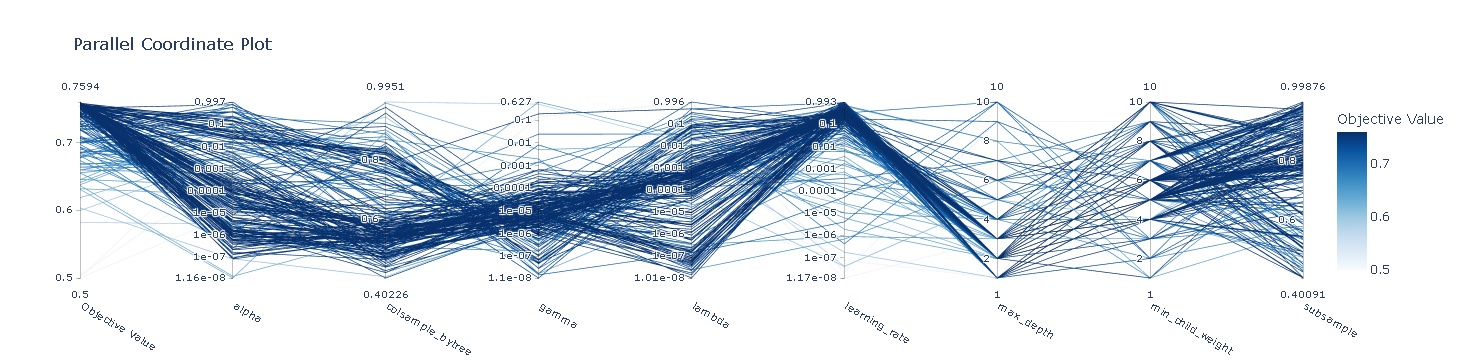

In [9]:
optuna.visualization.plot_parallel_coordinate(study)

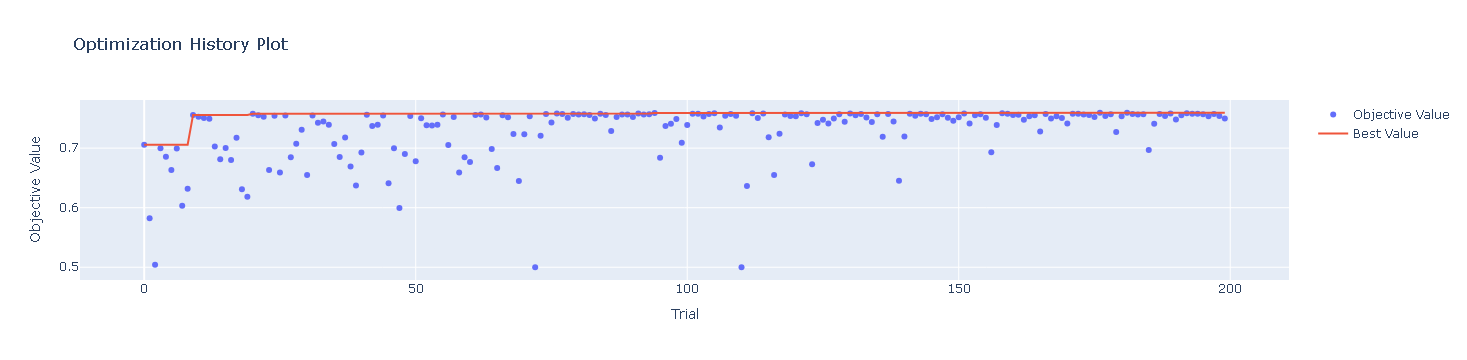

In [10]:
optuna.visualization.plot_optimization_history(study)

In [11]:
optuna.visualization.plot_param_importances(study)

## Visualización de los resultados

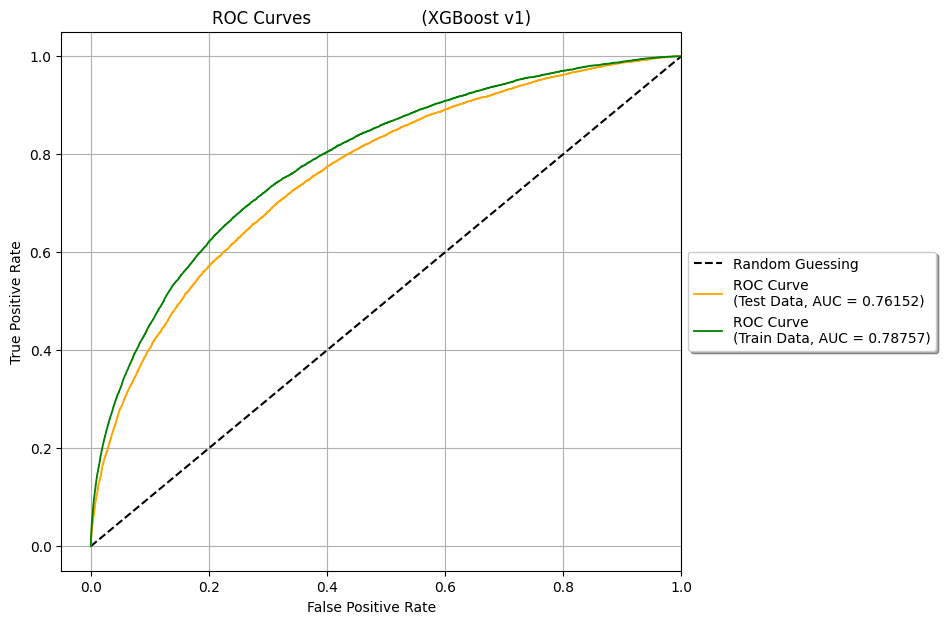

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix,roc_auc_score,precision_recall_fscore_support



# Initialization for the figure (ROC)
plt.figure(figsize=(8, 7))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Random Guessing')

# Compute predictions using the final_model
probs_pred_train = xgbModel.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, probs_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

probs_pred_test = xgbModel.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, probs_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)


# Plot ROC curves
plt.plot(fpr_test, tpr_test, lw=1.3, ls='-', label=f'ROC Curve \n(Test Data, AUC = {round(roc_auc_test,5)})', color='orange')
plt.plot(fpr_train, tpr_train, lw=1.3, ls='-', label=f'ROC Curve \n(Train Data, AUC = {round(roc_auc_train,5)})', color='green')

# Plot Configuration
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves                     (XGBoost v1)')
plt.grid(True)

# Legends
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()


## Análisis de umbral de probabilidad

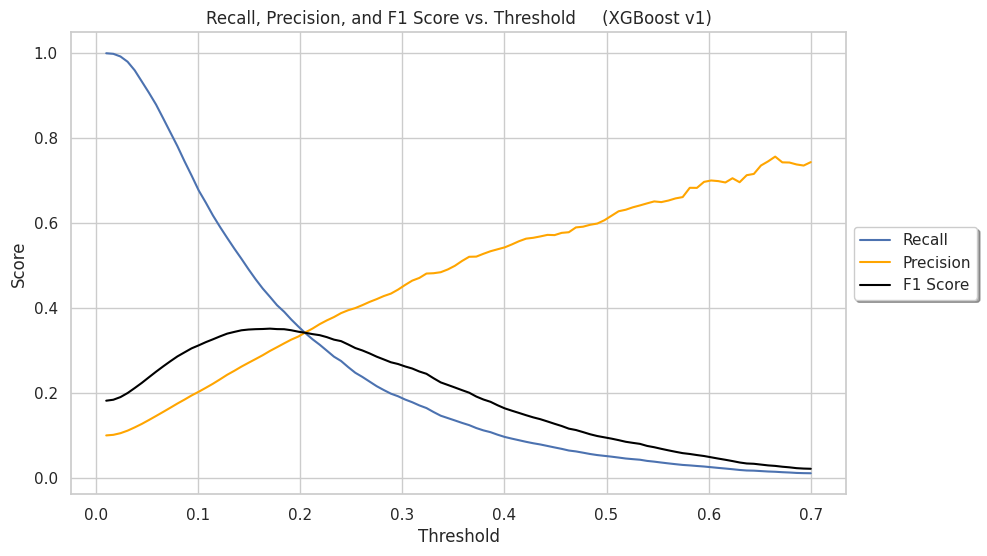

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns

# Obtener las mejores hiperparámetros
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros
xgbModel = xgb.XGBClassifier(**best_params)
xgbModel.fit(X_train, y_train)

# Inicialización de las listas para almacenar los valores de recall, precision, f1 score
recalls = []
precisions = []
f1_scores = []

# Obtener las probabilidades predichas
probs_pred_test = xgbModel.predict_proba(X_test)[:, 1]

# Definir los umbrales
thresholds = np.linspace(0.01, 0.7, 100)

# Iterar sobre diferentes umbrales
for threshold in thresholds:
    pred_labels = [1 if prob > threshold else 0 for prob in probs_pred_test]
    
    recall = recall_score(y_test, pred_labels)
    precision = precision_score(y_test, pred_labels)
    f1 = f1_score(y_test, pred_labels)
    
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

# Configuración de estilo Seaborn
sns.set(style="whitegrid")

# Inicialización de la figura
plt.figure(figsize=(10, 6))

# Graficar recall, precision y f1 score en función del umbral
sns.lineplot(x=thresholds, y=recalls, label='Recall')
sns.lineplot(x=thresholds, y=precisions, label='Precision', color='orange')
sns.lineplot(x=thresholds, y=f1_scores, label='F1 Score', color='black')

# Configuración de la gráfica
plt.title('Recall, Precision, and F1 Score vs. Threshold     (XGBoost v1)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.grid(True)
plt.show()

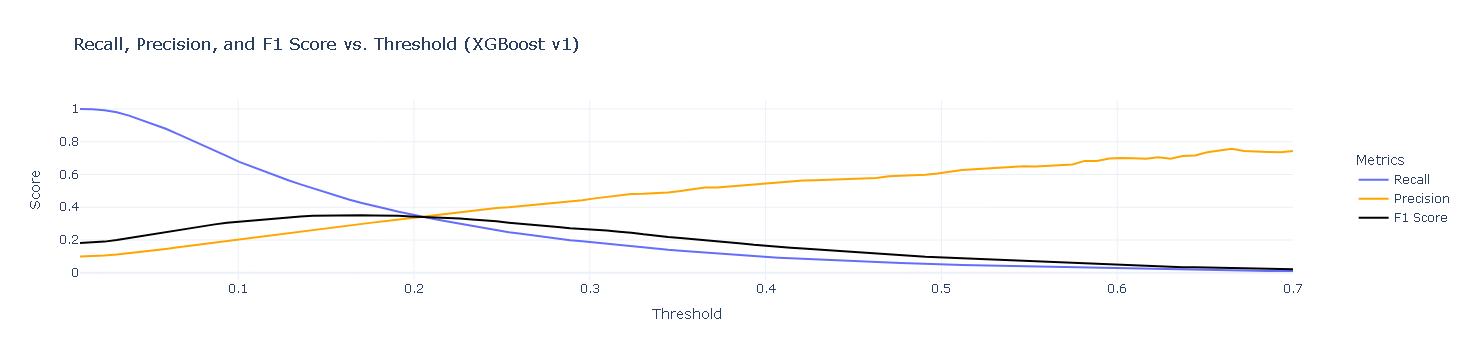

In [32]:
import plotly.graph_objects as go
# Crear figura para las métricas en función del umbral
fig_metrics = go.Figure()

# Añadir líneas para recall, precision y f1 score
fig_metrics.add_trace(go.Scatter(x=thresholds, y=recalls, mode='lines', name='Recall'))
fig_metrics.add_trace(go.Scatter(x=thresholds, y=precisions, mode='lines', name='Precision', line=dict(color='orange')))
fig_metrics.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1 Score', line=dict(color='black')))

# Configuración de la gráfica
fig_metrics.update_layout(
    title='Recall, Precision, and F1 Score vs. Threshold (XGBoost v1)',
    xaxis_title='Threshold',
    yaxis_title='Score',
    legend=dict(x=1.05, y=0.5),
    legend_title_text='Metrics',
    template='plotly_white'
)

# Mostrar la gráfica
fig_metrics.show()

##  Matriz de confusión para varios umbrales de probabilidad

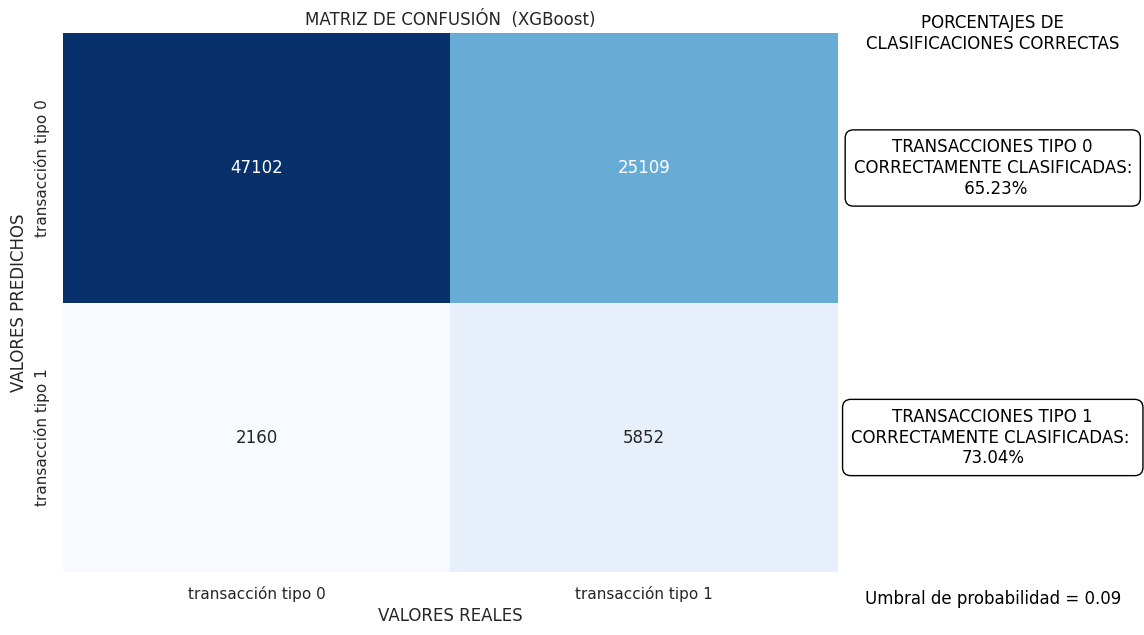

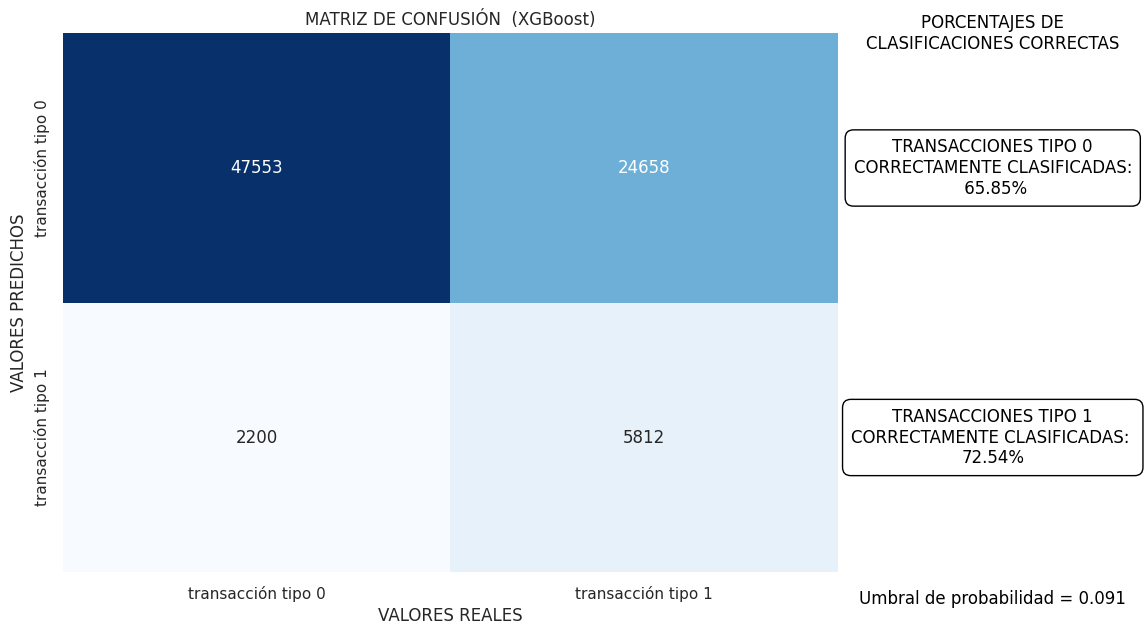

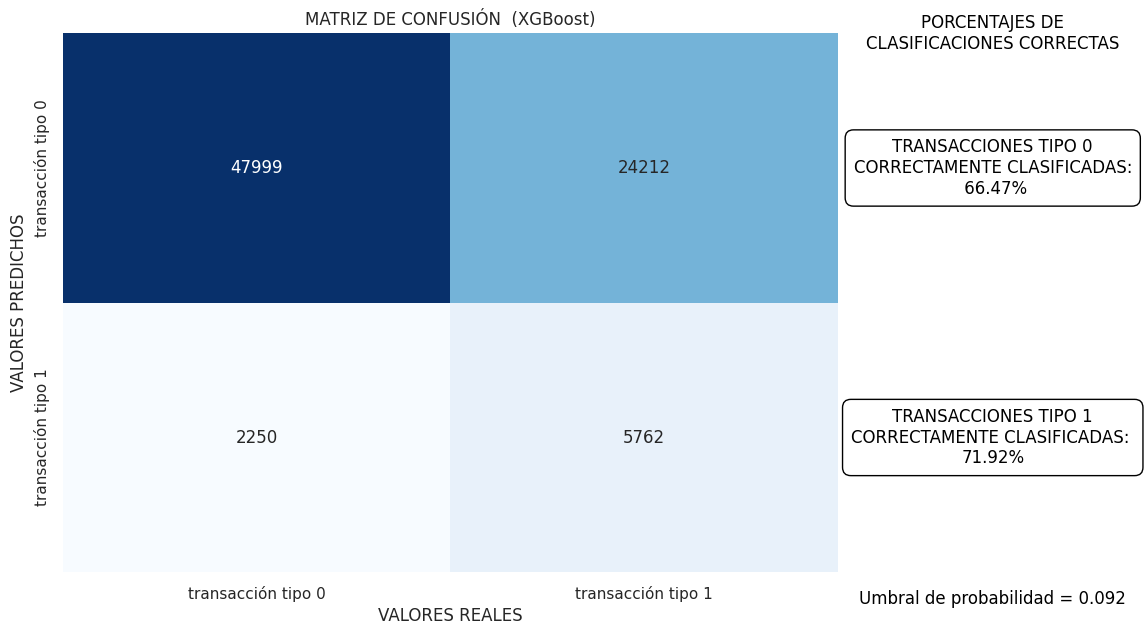

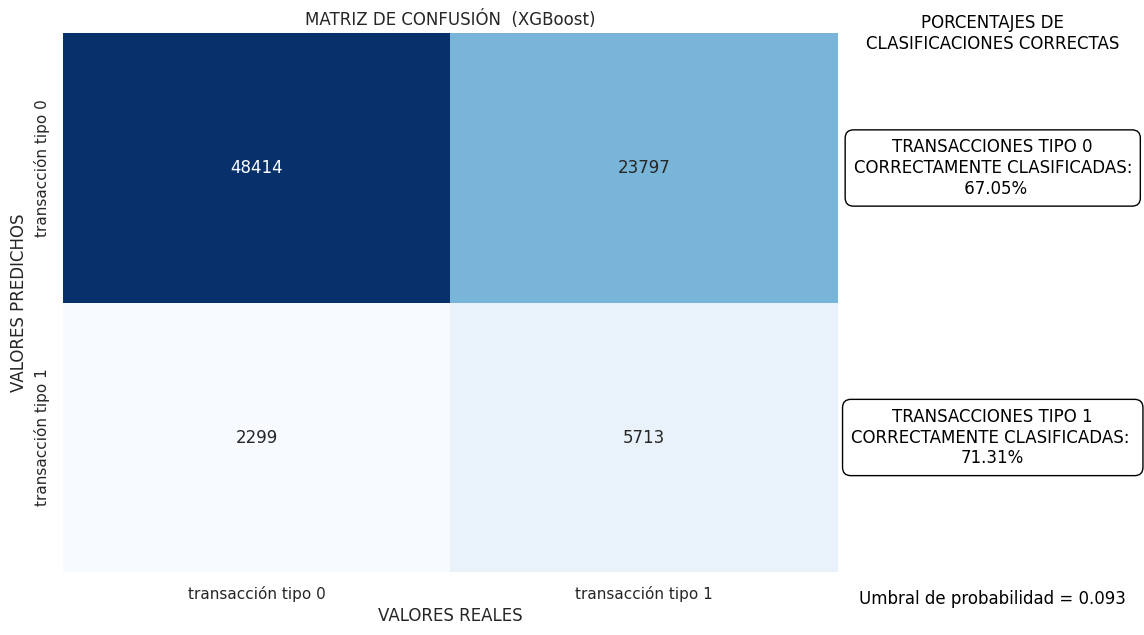

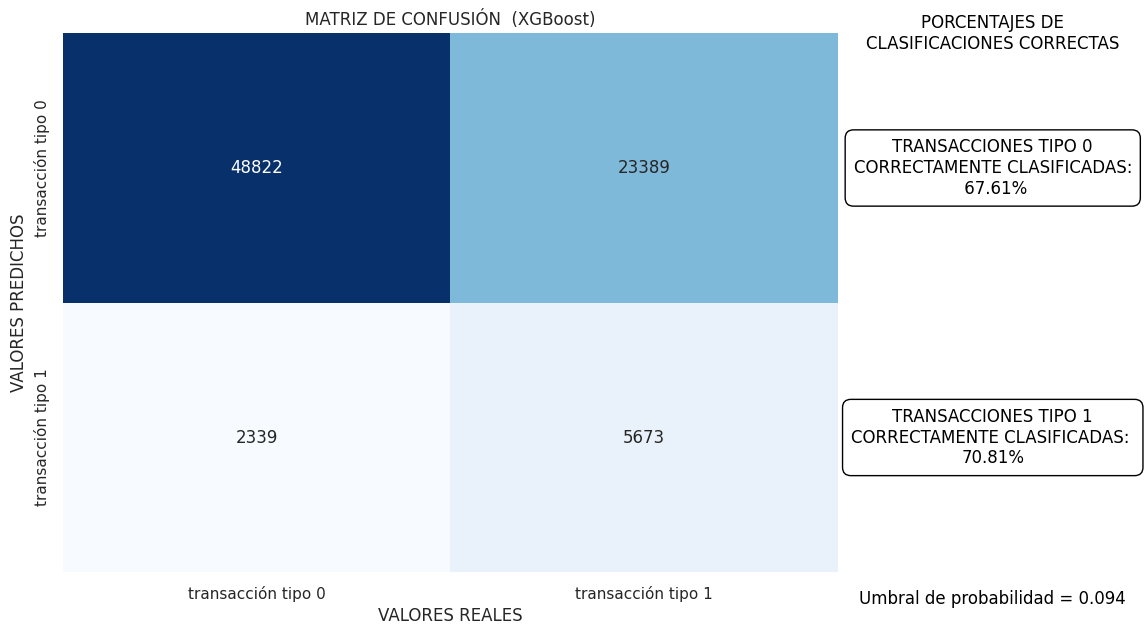

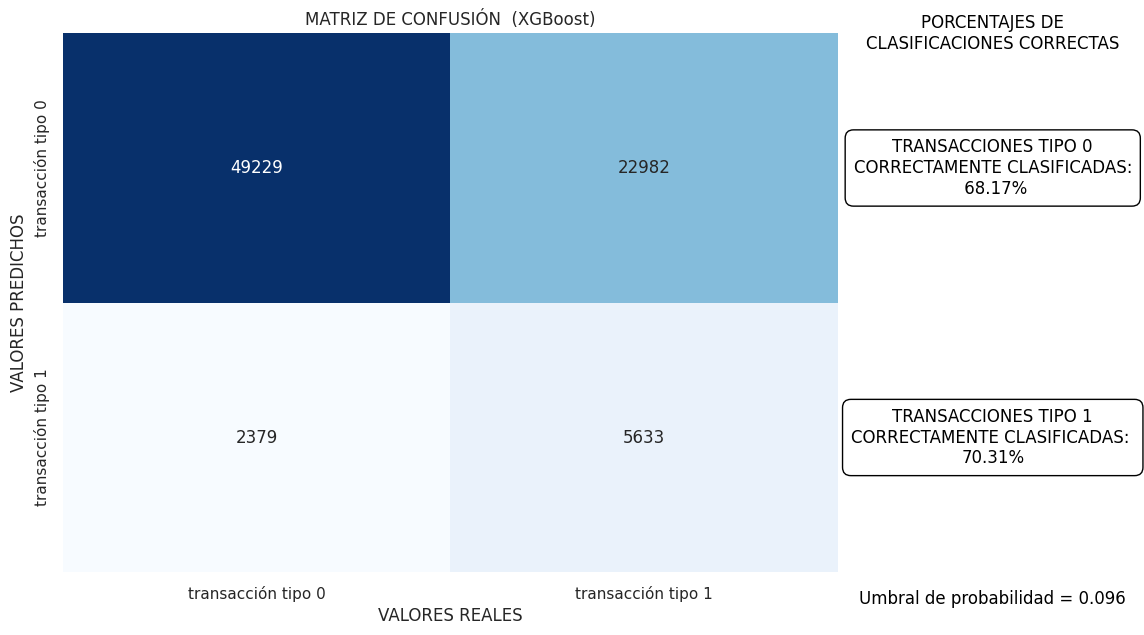

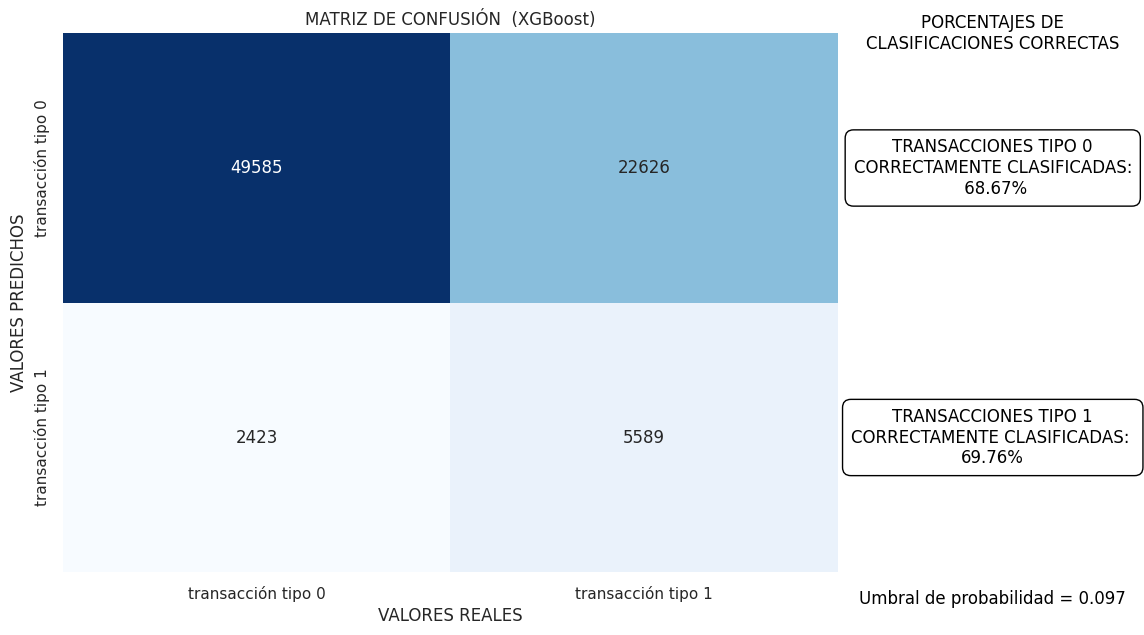

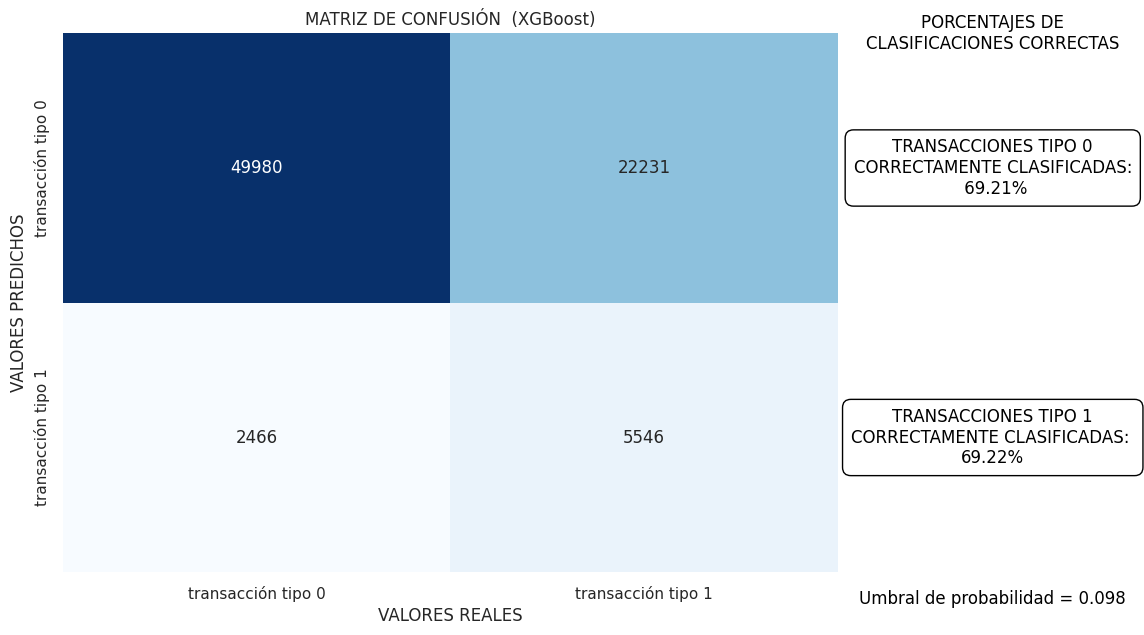

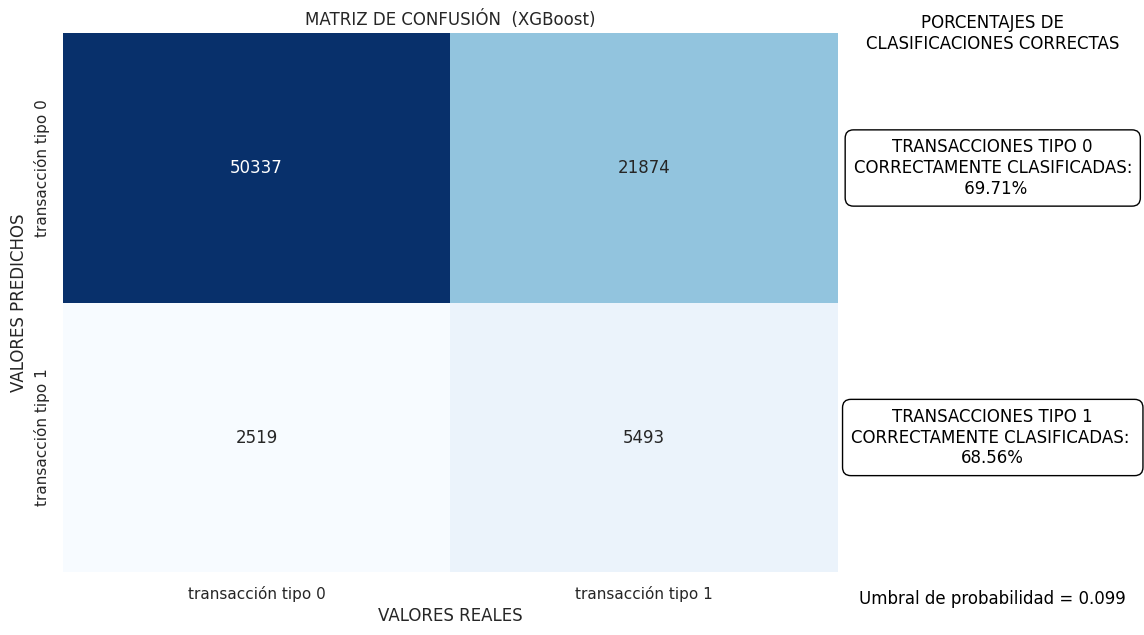

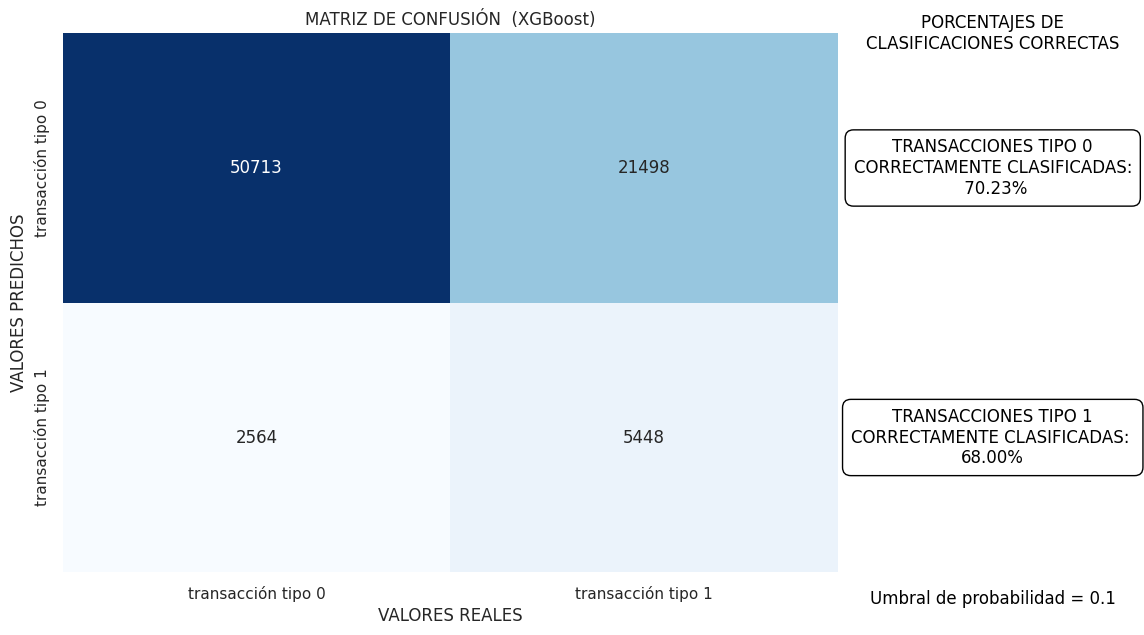

In [45]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

    # Definir el umbral de probabilidad
for  THRESHOLD in np.linspace(0.09, 0.1, 10):
    
    # Obtener las probabilidades predichas
    probs_pred_test = xgbModel.predict_proba(X_test)[:, 1]
    
    # Obtener las etiquetas predichas basadas en el umbral
    pred_labels = [1 if prob > THRESHOLD else 0 for prob in probs_pred_test]
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, pred_labels)
    
    # Crear un DataFrame a partir de la matriz de confusión para una mejor visualización con Seaborn
    cm_df = pd.DataFrame(cm, index=['transacción tipo 0', 'transacción tipo 1'],
                         columns=['transacción tipo 0', 'transacción tipo 1'])
    
    # Calcular los porcentajes para una interpretación más fácil
    percentage_without_difficulties_correctly_classified = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) * 100
    percentage_with_difficulties_correctly_classified = (cm[1, 1] / (cm[1, 0] + cm[1, 1])) * 100
    
    # Configurar el estilo de Seaborn
    sns.set(style="whitegrid")
    
    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('MATRIZ DE CONFUSIÓN  (XGBoost)')
    plt.xlabel('VALORES REALES')
    plt.ylabel('VALORES PREDICHOS')
    
    # Añadir leyendas con porcentajes
    plt.text(2.4, 0, "PORCENTAJES DE\nCLASIFICACIONES CORRECTAS", 
             fontsize=12, color='black', ha='center', va='center')
    plt.text(2.4, 0.5, f'TRANSACCIONES TIPO 0\nCORRECTAMENTE CLASIFICADAS:\n {percentage_without_difficulties_correctly_classified:.2f}%', 
             fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    plt.text(2.4, 1.5, f'TRANSACCIONES TIPO 1\nCORRECTAMENTE CLASIFICADAS: \n{percentage_with_difficulties_correctly_classified:.2f}%', 
             fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    plt.text(2.4, 2.1, f"Umbral de probabilidad = {round(THRESHOLD, 3)}", 
             fontsize=12, color='black', ha='center', va='center')
    plt.show()


## Mejor modelo: umbral de probabilidad = 0.098

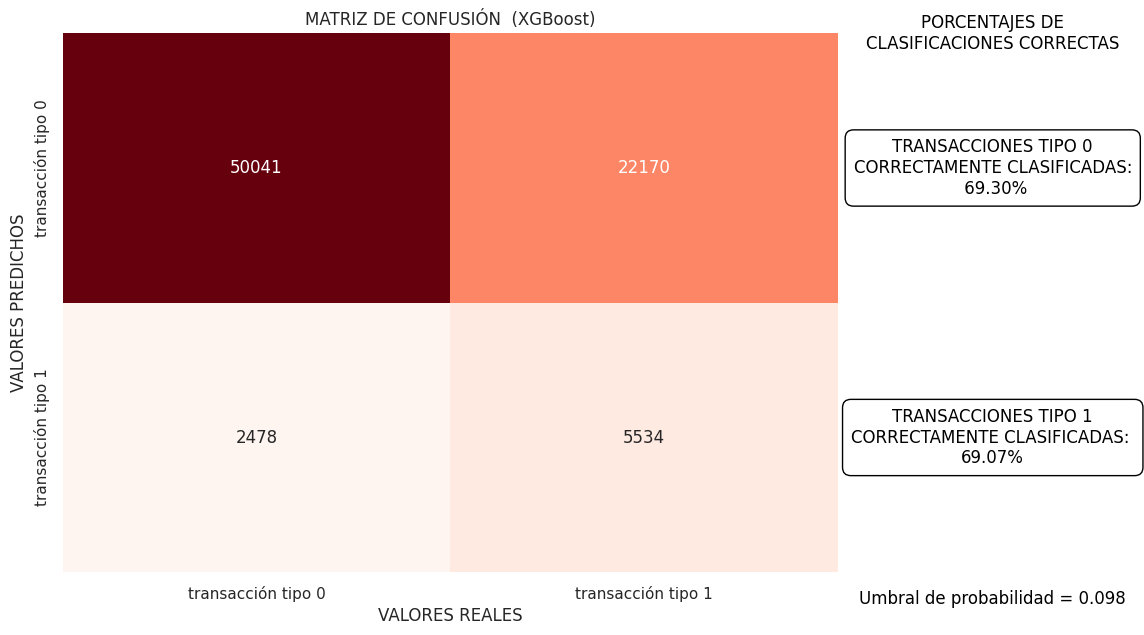

In [46]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

    # Definir el umbral de probabilidad
THRESHOLD  = 0.098


# Obtener las probabilidades predichas
probs_pred_test = xgbModel.predict_proba(X_test)[:, 1]

# Obtener las etiquetas predichas basadas en el umbral
pred_labels = [1 if prob > THRESHOLD else 0 for prob in probs_pred_test]

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, pred_labels)

# Crear un DataFrame a partir de la matriz de confusión para una mejor visualización con Seaborn
cm_df = pd.DataFrame(cm, index=['transacción tipo 0', 'transacción tipo 1'],
                     columns=['transacción tipo 0', 'transacción tipo 1'])

# Calcular los porcentajes para una interpretación más fácil
percentage_without_difficulties_correctly_classified = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) * 100
percentage_with_difficulties_correctly_classified = (cm[1, 1] / (cm[1, 0] + cm[1, 1])) * 100

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title('MATRIZ DE CONFUSIÓN  (XGBoost)')
plt.xlabel('VALORES REALES')
plt.ylabel('VALORES PREDICHOS')

# Añadir leyendas con porcentajes
plt.text(2.4, 0, "PORCENTAJES DE\nCLASIFICACIONES CORRECTAS", 
         fontsize=12, color='black', ha='center', va='center')
plt.text(2.4, 0.5, f'TRANSACCIONES TIPO 0\nCORRECTAMENTE CLASIFICADAS:\n {percentage_without_difficulties_correctly_classified:.2f}%', 
         fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(2.4, 1.5, f'TRANSACCIONES TIPO 1\nCORRECTAMENTE CLASIFICADAS: \n{percentage_with_difficulties_correctly_classified:.2f}%', 
         fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(2.4, 2.1, f"Umbral de probabilidad = {round(THRESHOLD, 3)}", 
         fontsize=12, color='black', ha='center', va='center')
plt.show()


## Guardar el mejor modelo

Tras comparar con la matriz de confusión del mejor modelo que utiliza regresión logística, vemos que el mejor modelo de XGBoost es ligeramente mejor por lo que lo guardamos.